In [ ]:
import pandas as pd

#Parameterize S3 locations
#raw_data_location='s3://anomaly-detection-team-vypin/PS_20174392719_1491204439457_log.csv'
#output_data_location_random_shuffled='s3://anomaly-detection-team-vypin/data.csv'

#For local
paysim_df=pd.read_csv('./../testdata/PS_20174392719_1491204439457_log.csv')
output_data_location_random_shuffled='./../testdata/data_out.csv'
paysim_df.head()

In [2]:
#Check data Types
paysim_df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [3]:
#Data cleansing
#Drop name columns
paysim_df_reduced=paysim_df.drop(columns=['nameDest','nameOrig'])
paysim_df_reduced.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [4]:
#Data analysis to categorize into bins
bins = range(0, 1000000, 50000) #paysim_df_reduced
labels = range(0, 950000, 50000)
paysim_etl=paysim_df_reduced.copy() #deep = true by default. to reatin link and inx use deep=false
paysim_etl['binned'] = pd.cut(paysim_etl['amount'], bins=bins, labels=labels)
paysim_etl[['amount']].plot(kind='hist',bins=bins,rwidth=0.8)

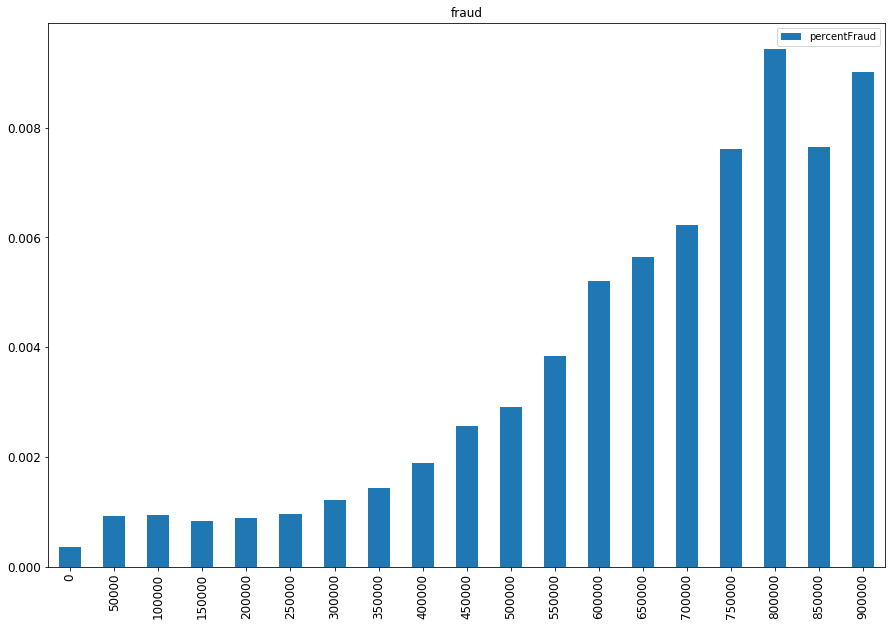

In [5]:
#Data analysis to categorize frauds
result = paysim_etl['binned'].value_counts().to_frame('totalTx')
result['bin'] = result.index
fraud = paysim_etl.loc[paysim_df_reduced['isFraud'] == 0].groupby(['binned']).size().to_frame('nonfraud')
result = result.join(fraud, lsuffix='', rsuffix='', sort=False)
result['percentFraud'] = (result['totalTx'] - result['nonfraud'])/result['totalTx']
result[['bin','percentFraud']].plot(kind='bar', title ="fraud", figsize=(15, 10), legend=True, fontsize=12)

In [6]:
#Perform Hot Encoding (Use Pandas get dummies)
paysim_df_hotencoded=pd.get_dummies(paysim_df_reduced)

paysim_df_hotencoded.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


In [7]:
#List columns to have isfraud moved. See below
cols = paysim_df_hotencoded.columns.tolist()
cols.insert(0, cols.pop(cols.index('isFraud')))
final_data = paysim_df_hotencoded.reindex(columns= cols)

In [8]:
final_data.head()

,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,0,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,0,0,1,0,0,0
4,0,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


In [9]:
#Shuffle data 
from sklearn.utils import shuffle
final_shuff_data=shuffle(final_data)

#Write shuffled data to output location
#final_data_shuffled.to_csv(output_data_location_random_shuffled)

final_shuff_data.head()

,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
386079,0,17,136253.07,107.0,0.00,1555.11,137808.18,0,0,1,0,0,0
6046869,0,492,2818757.61,169.0,0.00,9684643.21,12503400.82,0,0,0,0,0,1
6312424,0,686,7940.95,369140.0,377080.95,149538.12,141597.17,0,1,0,0,0,0
1922598,0,167,744.10,11034.0,10289.90,0.00,0.00,0,0,0,0,1,0
1747326,0,161,82837.94,0.0,0.00,345086.98,349881.37,0,0,1,0,0,0
